# CUDA Memory Transfer Performance Analysis

This notebook compares pageable (`new[]`) vs pinned (`cudaHostAlloc`) memory transfer performance for GPU operations.

In [1]:
import subprocess
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Compile the program first
print("Compiling compare_mem_access...")
result = subprocess.run(['make', 'compare_mem_access'],
                       cwd='/home/yucheng/workspace/ECE455/Proj',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Compiling compare_mem_access...
✓ Compilation successful


# Compare memory access: pageable vs. pinned

In [2]:
# Run benchmarks
test_sizes = [64, 128, 256, 512, 1024]
csv_file = '/home/yucheng/workspace/ECE455/Proj/compare_mem_access_output.csv'
num_runs = 5

# Collect data from each run
all_data = []
for size in tqdm(test_sizes, desc="Test sizes", unit="size"):
    for run in tqdm(range(num_runs), desc=f"{size} MB", unit="run"):
        subprocess.run(['./compare_mem_access', str(size)],
                       cwd='/home/yucheng/workspace/ECE455/Proj',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file)
        all_data.append(run_df)

# Combine all runs and calculate averages
raw_df = pd.concat(all_data, ignore_index=True)
df = raw_df.groupby(['size_mb', 'memory_type']).mean().reset_index()
print(f"\nCollected {len(raw_df)} measurements, averaged to {len(df)} results")
df

Test sizes: 100%|██████████| 5/5 [00:22<00:00,  4.43s/size]


Collected 50 measurements, averaged to 10 results


,size_mb,memory_type,h2d_ms,h2d_gbps,d2h_ms,d2h_gbps
0,64,Pageable,8.298,7.736,5.860,10.680
1,64,Pinned,5.000,12.500,4.910,12.722
2,128,Pageable,15.382,8.176,12.544,10.018
3,128,Pinned,10.274,12.172,9.958,12.552
4,256,Pageable,27.940,8.966,26.446,9.614
5,256,Pinned,20.332,12.296,19.892,12.566
6,512,Pageable,51.976,9.628,49.520,10.130
7,512,Pinned,42.364,11.802,42.398,11.820
8,1024,Pageable,102.230,9.796,103.740,9.646
9,1024,Pinned,83.894,11.922,86.658,11.542


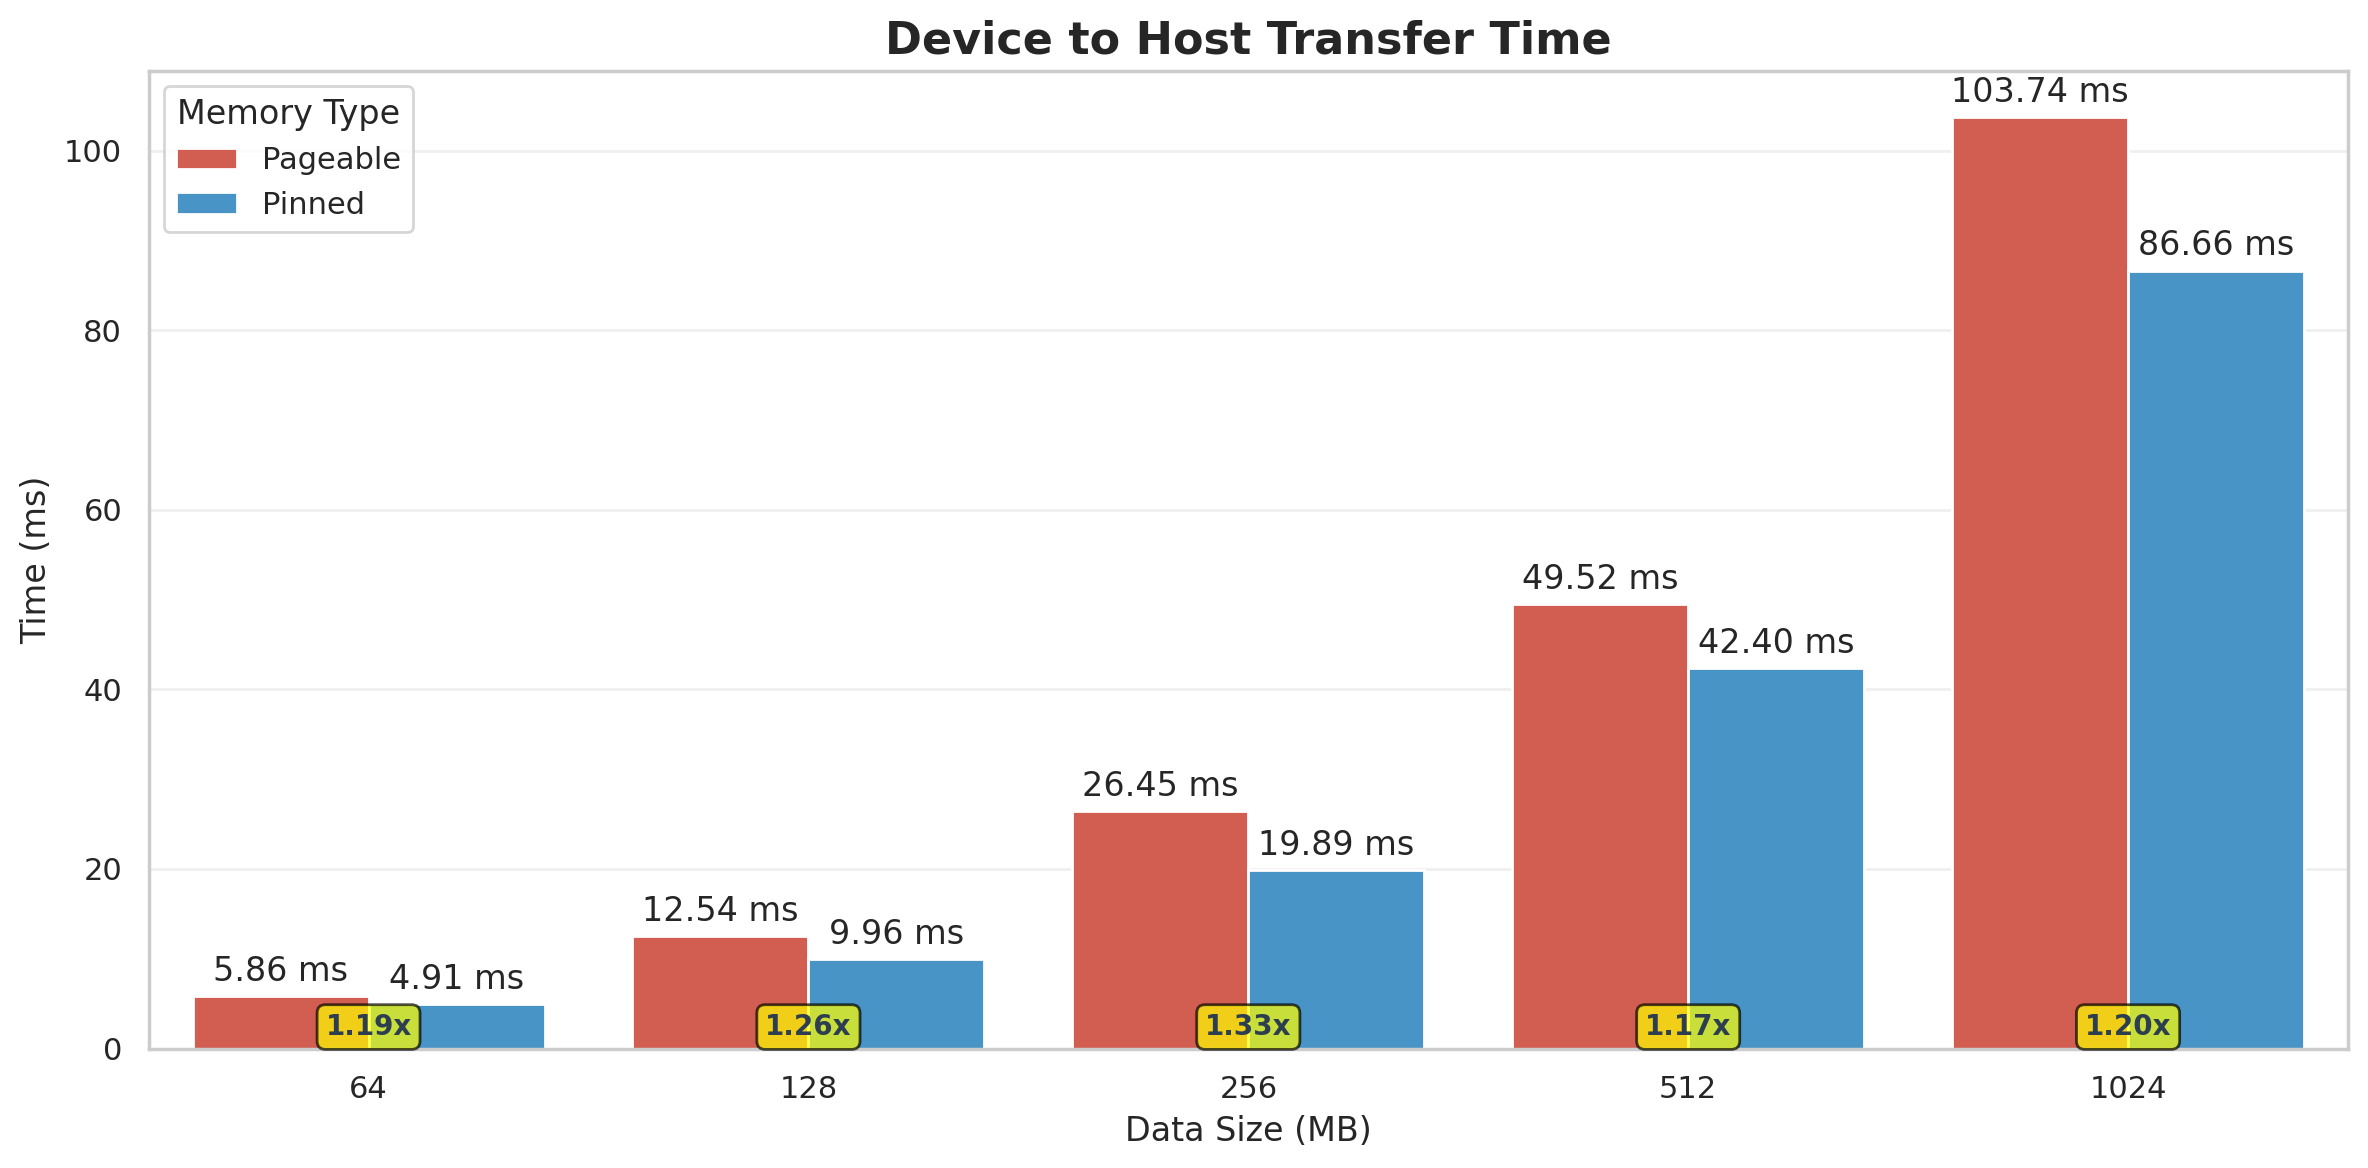

In [3]:
# Device to Host Transfer Time
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.barplot(data=df, x='size_mb', y='d2h_ms', hue='memory_type', 
            palette=['#e74c3c', '#3498db'], ax=ax)

plt.title('Device to Host Transfer Time', fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Data Size (MB)', fontsize=12)
ax.legend(title='Memory Type', loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f ms', padding=3)

# Add speedup annotations between bars
for i, size in enumerate(test_sizes):
    pageable_time = df[(df['size_mb'] == size) & (df['memory_type'] == 'Pageable')]['d2h_ms'].values[0]
    pinned_time = df[(df['size_mb'] == size) & (df['memory_type'] == 'Pinned')]['d2h_ms'].values[0]
    speedup = pageable_time / pinned_time
    
    # Draw speedup text at the bottom
    ax.annotate(f'{speedup:.2f}x', xy=(i, 1.5), ha='center', 
                fontsize=10, fontweight='bold', color='#2c3e50',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show() 

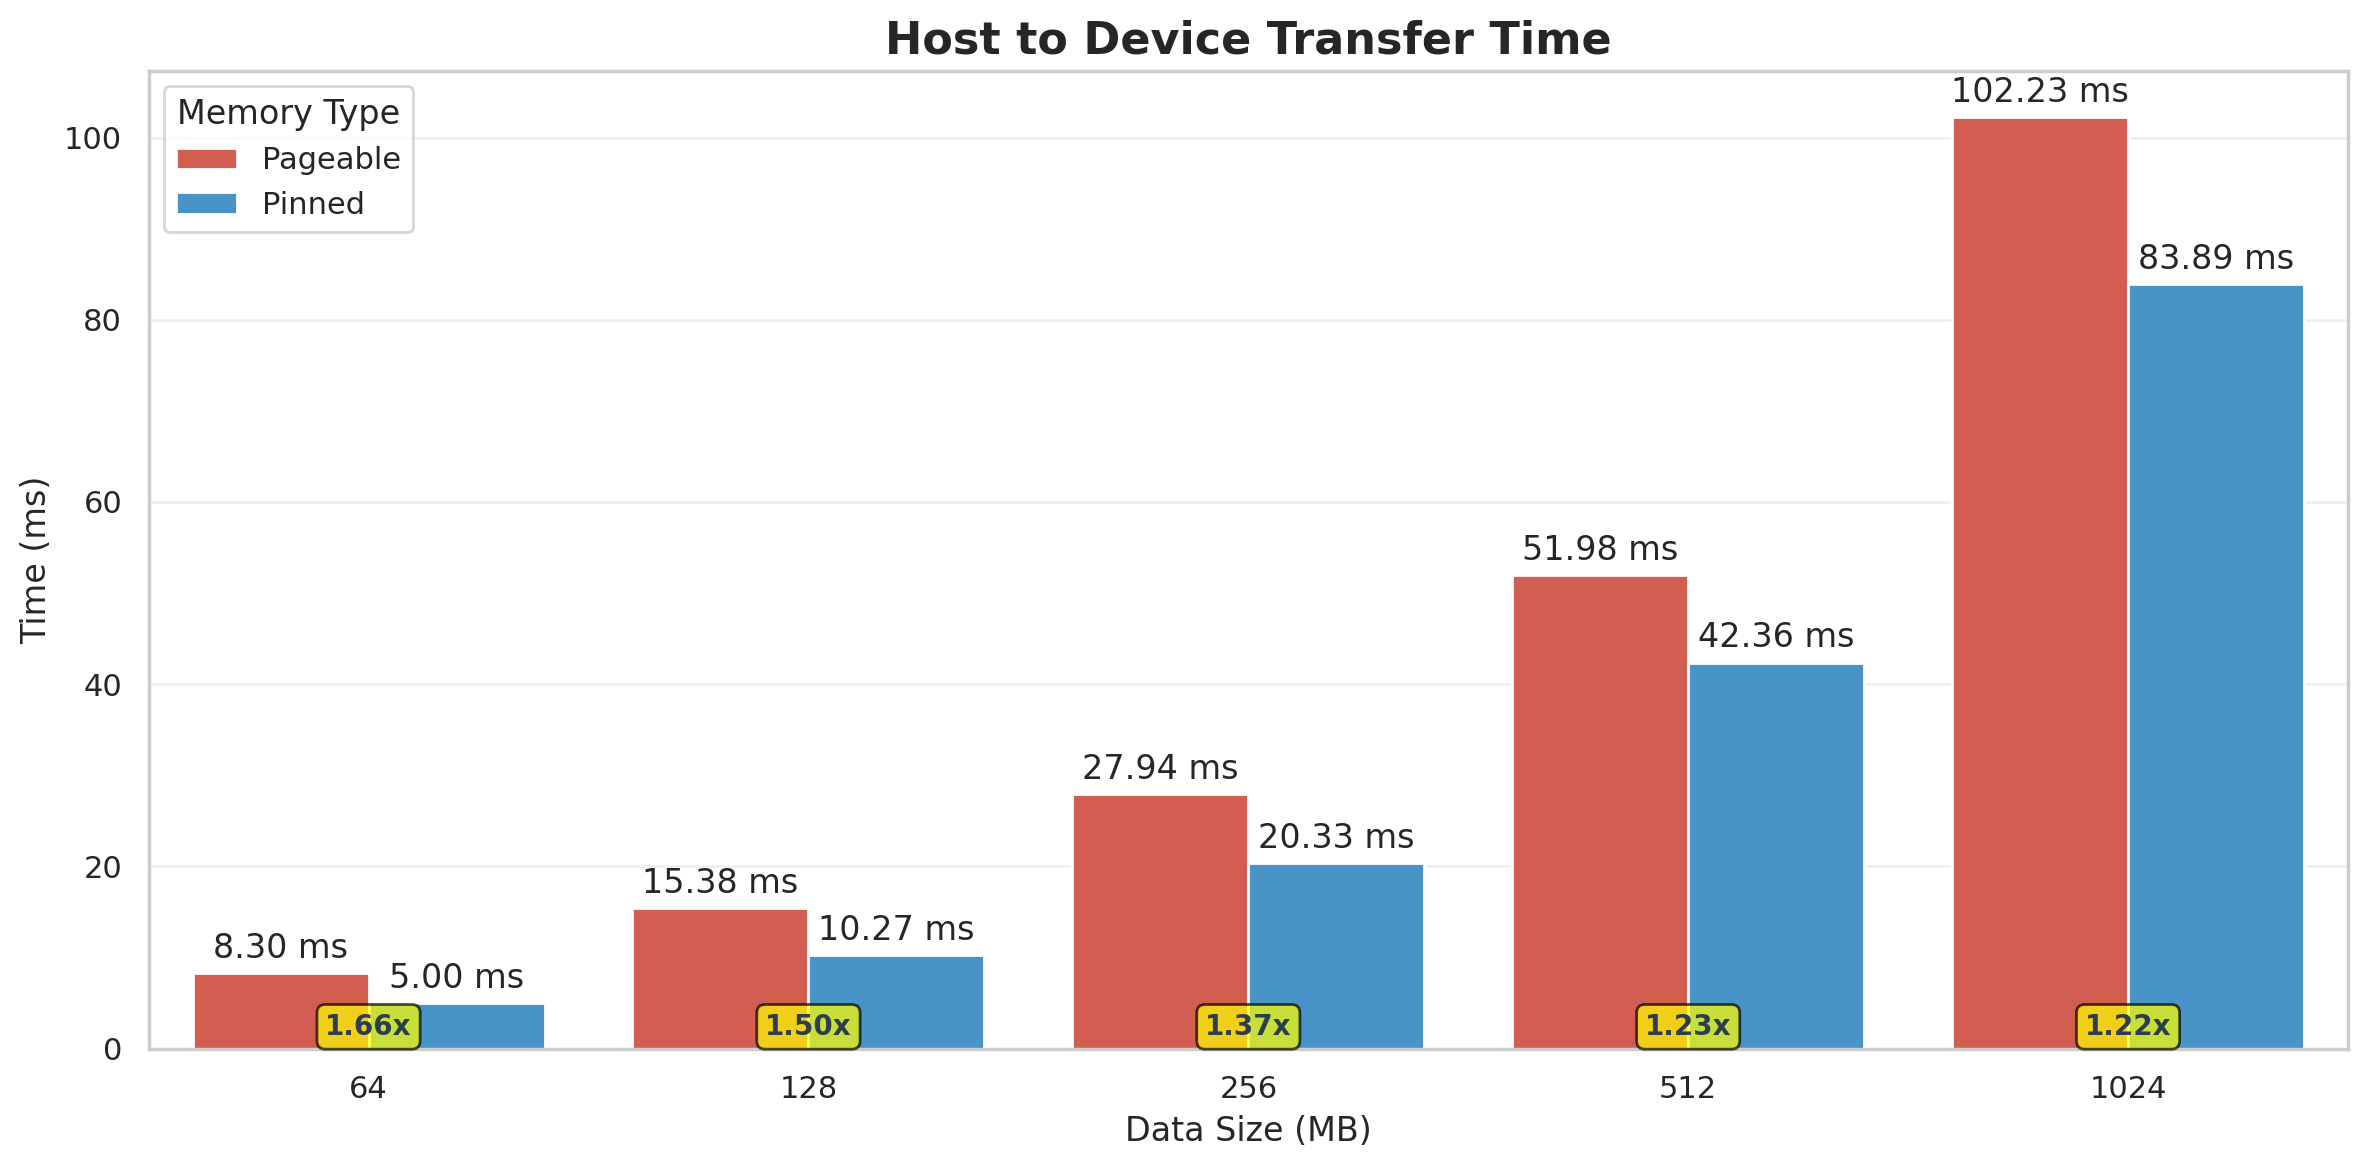

In [4]:
# Host to Device Transfer Time
fig, ax = plt.subplots(figsize=(12, 6) , dpi=200)
sns.barplot(data=df, x='size_mb', y='h2d_ms', hue='memory_type', 
            palette=['#e74c3c', '#3498db'], ax=ax)

plt.title('Host to Device Transfer Time', fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Data Size (MB)', fontsize=12)
ax.legend(title='Memory Type', loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f ms', padding=3)

# Add speedup annotations between bars
for i, size in enumerate(test_sizes):
    pageable_time = df[(df['size_mb'] == size) & (df['memory_type'] == 'Pageable')]['h2d_ms'].values[0]
    pinned_time = df[(df['size_mb'] == size) & (df['memory_type'] == 'Pinned')]['h2d_ms'].values[0]
    speedup = pageable_time / pinned_time
    
    # Draw speedup text at the bottom
    ax.annotate(f'{speedup:.2f}x', xy=(i, 1.5), ha='center', 
                fontsize=10, fontweight='bold', color='#2c3e50',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show() 

# Compare memory layout: separate vs. combined

# Memory Layout Comparison (Separate vs Combined)

Comparing separate arrays (A, B, C, D) vs combined interleaved memory layout.

In [5]:
# Compile compare_mem_layout
print("Compiling compare_mem_layout...")
result = subprocess.run(['make', 'compare_mem_layout'],
                       cwd='/home/yucheng/workspace/ECE455/Proj',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_mem_layout...
✓ Compilation successful


In [6]:
# Run memory layout benchmarks
test_configs = [(1000000, 64), (1000000, 128), (2000000, 64), (2000000, 128)]
csv_file_layout = '/home/yucheng/workspace/ECE455/Proj/compare_mem_layout_output.csv'
num_runs_layout = 5

# Collect data from each run
all_layout_data = []
for num_matrices, threads in tqdm(test_configs, desc="Test configs", unit="config"):
    for run in tqdm(range(num_runs_layout), desc=f"{num_matrices}×{threads}", leave=False, unit="run"):
        subprocess.run(['./compare_mem_layout', str(num_matrices), str(threads)],
                       cwd='/home/yucheng/workspace/ECE455/Proj',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file_layout)
        all_layout_data.append(run_df)

# Combine all runs and calculate averages
raw_layout_df = pd.concat(all_layout_data, ignore_index=True)
layout_df = raw_layout_df.groupby(['num_matrices', 'threads_per_block', 'layout']).mean().reset_index()
print(f"\nCollected {len(raw_layout_df)} measurements, averaged to {len(layout_df)} results")
layout_df

Test configs: 100%|██████████| 4/4 [01:20<00:00, 20.13s/config]


Collected 40 measurements, averaged to 8 results


,num_matrices,threads_per_block,layout,cpu_ms,omp_ms,gpu_ms,xfer_ms,total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup
0,1000000,64,Combined,38.4520,10.0340,1.1820,30.7540,31.9360,10.02,38.76,330.76,1.204
1,1000000,64,Separate,26.5652,13.4968,3.0644,28.6290,31.6934,14.54,29.20,126.94,0.840
2,1000000,128,Combined,37.7560,7.8720,1.1900,30.8980,32.0880,10.24,49.58,327.68,1.176
3,1000000,128,Separate,27.5194,14.5638,3.2396,28.5614,31.8010,13.98,27.00,121.66,0.868
4,2000000,64,Combined,71.6440,13.0920,1.8980,60.2620,62.1660,10.76,59.42,405.02,1.154
5,2000000,64,Separate,52.3244,19.1296,4.9454,55.9346,60.8800,14.72,40.36,205.74,0.864
6,2000000,128,Combined,74.9820,14.2880,2.0660,59.9140,61.9800,10.28,54.12,375.04,1.208
7,2000000,128,Separate,54.8318,20.6680,3.3462,55.8068,59.1530,14.12,37.98,236.02,0.926


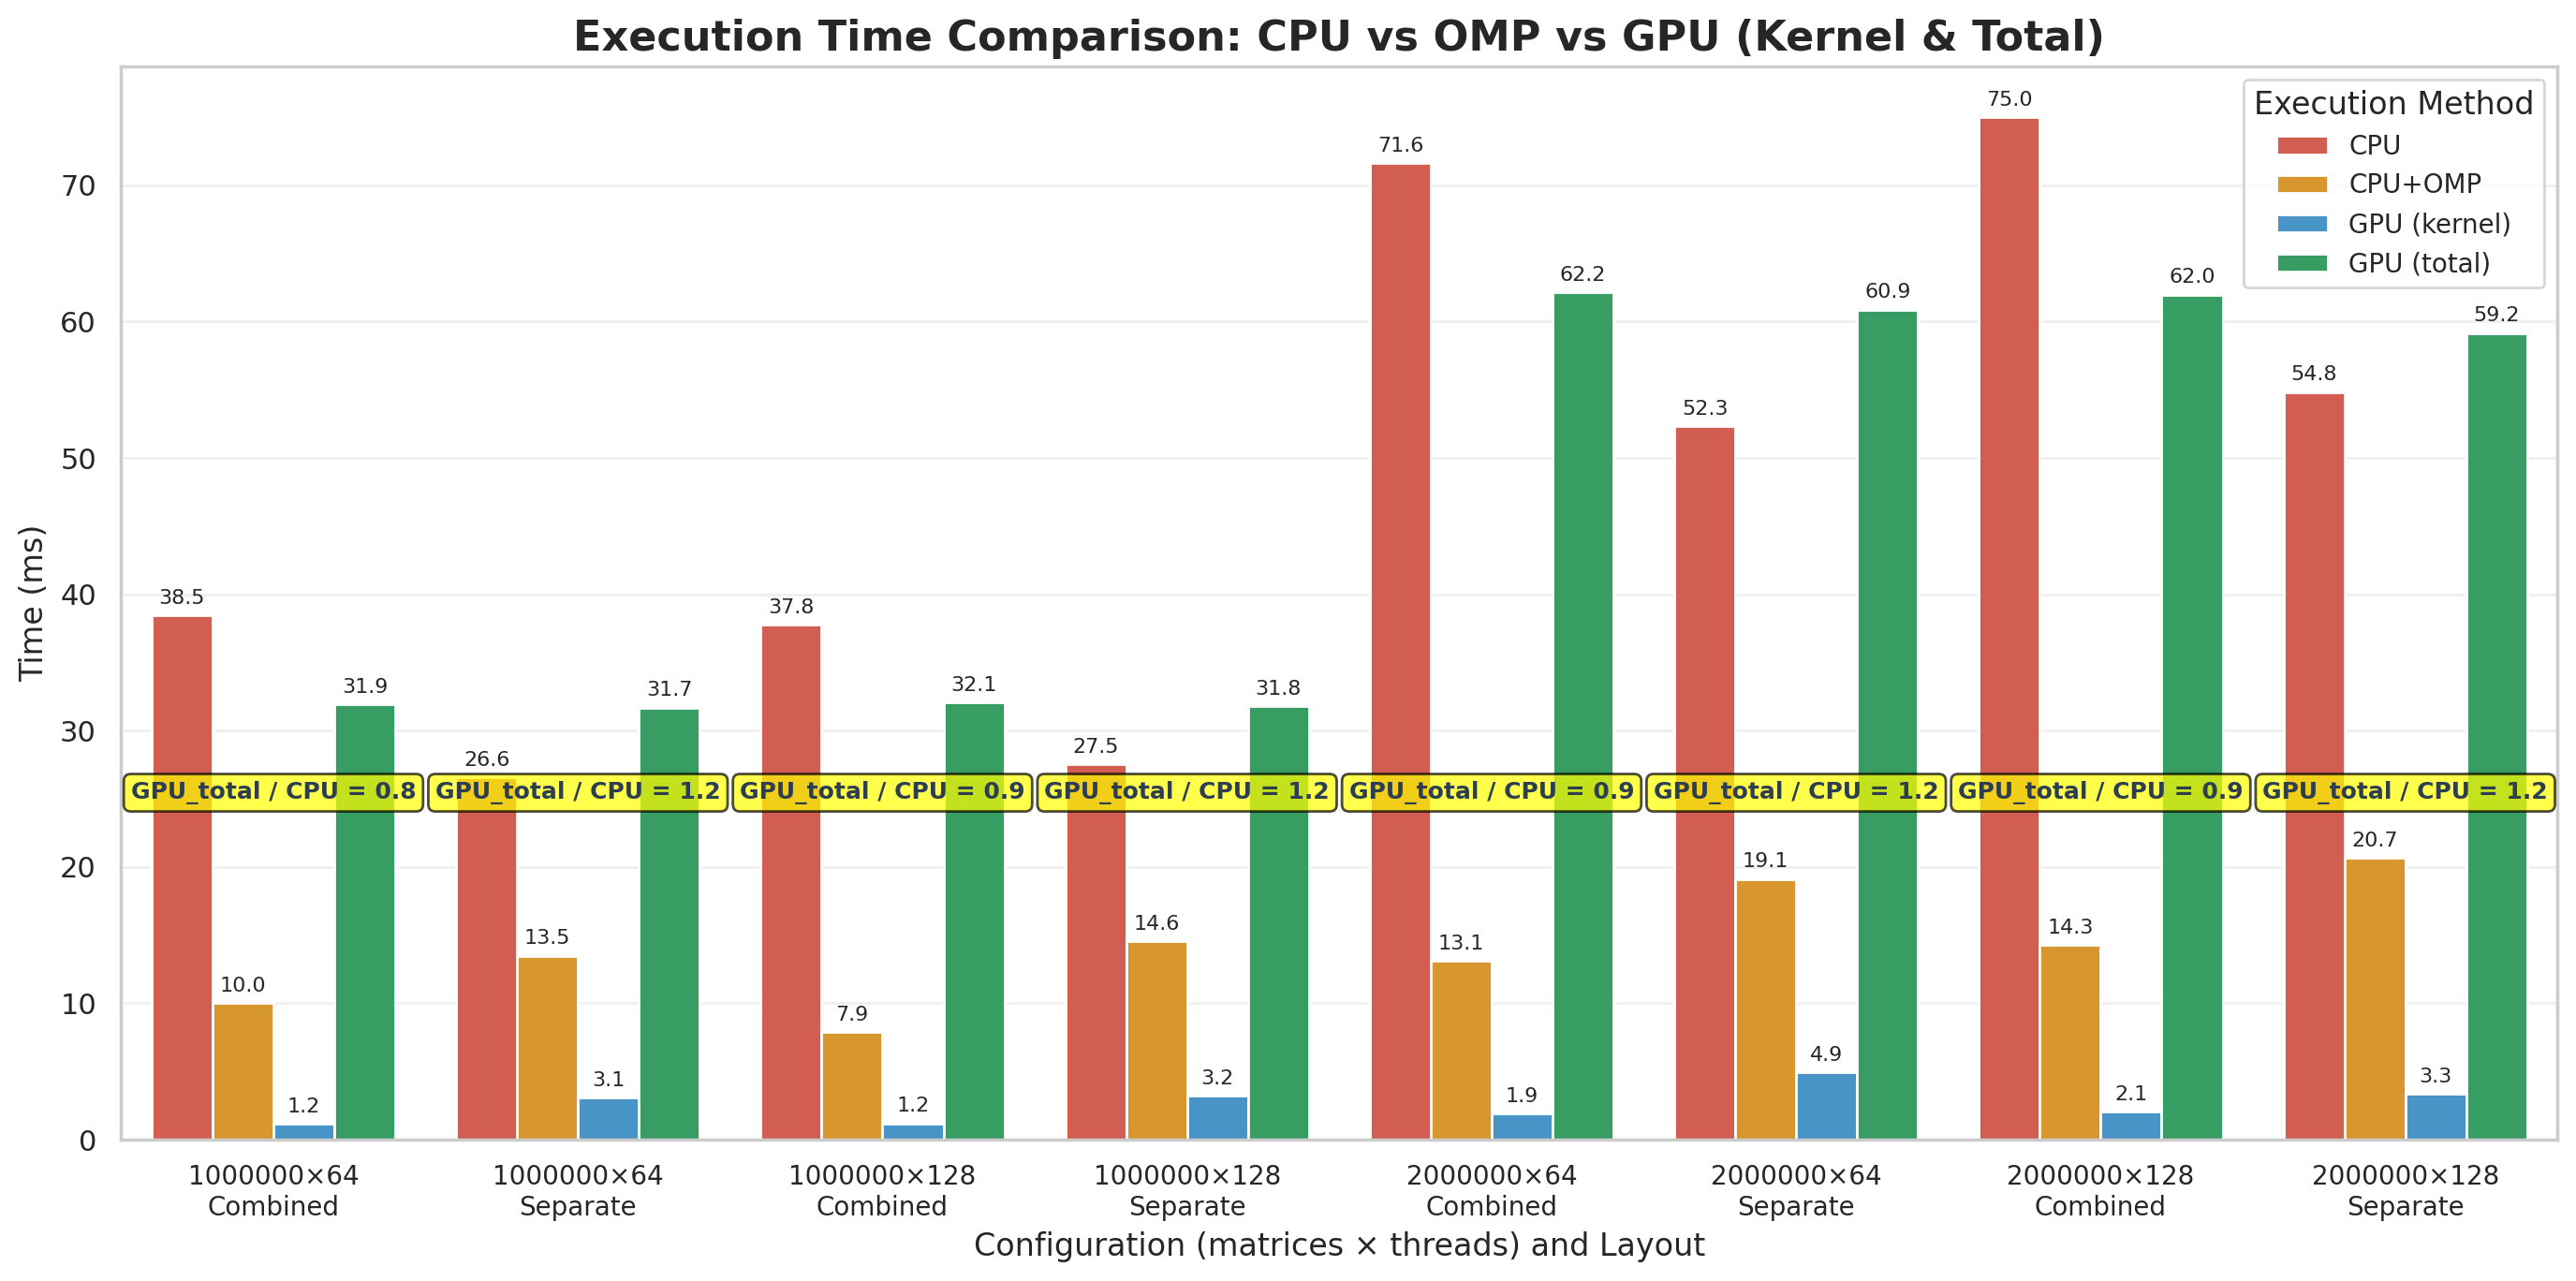

In [9]:
# Execution Time Comparison: CPU, OMP, GPU (kernel), and GPU (total w/ transfer)
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

# Create config column first
layout_df['config'] = layout_df['num_matrices'].astype(str) + '×' + layout_df['threads_per_block'].astype(str)

# Reshape data for better visualization - create separate bars for each execution method
plot_data = []
for _, row in layout_df.iterrows():
    config = row['config']
    layout = row['layout']
    plot_data.append({'config': config, 'layout': layout, 'method': 'CPU', 'time_ms': row['cpu_ms']})
    plot_data.append({'config': config, 'layout': layout, 'method': 'CPU+OMP', 'time_ms': row['omp_ms']})
    plot_data.append({'config': config, 'layout': layout, 'method': 'GPU (kernel)', 'time_ms': row['gpu_ms']})
    plot_data.append({'config': config, 'layout': layout, 'method': 'GPU (total)', 'time_ms': row['total_ms']})

plot_df = pd.DataFrame(plot_data)

# Create combined x-axis labels (config + layout)
plot_df['x_label'] = plot_df['config'] + '\n' + plot_df['layout']

sns.barplot(data=plot_df, x='x_label', y='time_ms', hue='method',
            palette=['#e74c3c', '#f39c12', '#3498db', '#27ae60'], ax=ax)

plt.title('Execution Time Comparison: CPU vs OMP vs GPU (Kernel & Total)', 
          fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Configuration (matrices × threads) and Layout', fontsize=12)
ax.legend(title='Execution Method', loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)

# Add GPU speedup annotations (GPU total vs CPU)
configs = layout_df['config'].unique()
for i, config in enumerate(configs):
    for j, layout in enumerate(['Separate', 'Combined']):
        x_pos = i * 2 + j
        cpu_time = layout_df[(layout_df['config'] == config) & (layout_df['layout'] == layout)]['cpu_ms'].values[0]
        gpu_time = layout_df[(layout_df['config'] == config) & (layout_df['layout'] == layout)]['total_ms'].values[0]
        speedup = cpu_time / gpu_time
        
        # Place speedup annotation at bottom
        ax.annotate(f'GPU_total / CPU = {speedup:.1f}', xy=(x_pos, 25), ha='center',
                    fontsize=9, fontweight='bold', color='#2c3e50',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'))

plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Compare variable joints

# Variable Joints Benchmark Analysis

Analyzing the performance impact of chain length (number of joints) on matrix multiplication.

In [10]:
# Compile and run variable joints benchmark
print("Compiling compare_variable_joints...")
result = subprocess.run(['make', 'compare_variable_joints'],
                       cwd='/home/yucheng/workspace/ECE455/Proj',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_variable_joints...
✓ Compilation successful


In [16]:
# Run variable joints benchmark with multiple runs and averaging
csv_file_joints = '/home/yucheng/workspace/ECE455/Proj/compare_variable_joints_output.csv'
num_runs_joints = 5

# Collect data from each run
all_joints_data = []
for run in tqdm(range(num_runs_joints), desc="Variable joints runs", unit="run"):
    subprocess.run(['./compare_variable_joints', '500000', '64'],
                   cwd='/home/yucheng/workspace/ECE455/Proj',
                   capture_output=True)
    # Read CSV after each run and accumulate
    run_df = pd.read_csv(csv_file_joints)
    all_joints_data.append(run_df)

# Combine all runs and calculate averages
raw_joints_df = pd.concat(all_joints_data, ignore_index=True)
joints_df = raw_joints_df.groupby(['num_joints']).mean().reset_index()
print(f"\nCollected {len(raw_joints_df)} measurements, averaged to {len(joints_df)} results")
joints_df

Variable joints runs: 100%|██████████| 5/5 [01:26<00:00, 17.26s/run]


Collected 80 measurements, averaged to 16 results


,num_joints,num_ops,threads_per_block,cpu_ms,omp_ms,gpu_kernel_ms,transfer_ms,total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup,correct
0,2,500000.0,64.0,13.3286,9.4630,2.6944,8.9576,11.6520,4.816,7.150,25.956,1.164,1.0
1,4,500000.0,64.0,18.1998,8.3340,0.7006,15.4808,16.1814,10.560,23.726,275.188,1.126,1.0
2,6,500000.0,64.0,19.0368,7.0010,1.0526,20.7344,21.7870,16.816,47.826,313.362,0.878,1.0
3,8,500000.0,64.0,26.5876,6.8430,1.0662,27.0626,28.1288,16.896,68.358,431.648,0.946,1.0
4,10,500000.0,64.0,32.0132,7.7210,1.4340,32.7466,34.1806,18.078,75.818,408.220,0.940,1.0
5,12,500000.0,64.0,40.6932,8.6796,2.4140,38.4732,40.8872,17.340,82.332,294.028,0.996,1.0
6,14,500000.0,64.0,46.0370,10.9114,2.7746,44.8638,47.6384,18.084,76.744,301.032,0.966,1.0
7,16,500000.0,64.0,54.5286,9.4420,3.6560,51.3296,54.9856,17.630,102.142,264.260,0.994,1.0
8,18,500000.0,64.0,58.7422,12.0182,3.3810,56.1438,59.5248,18.540,92.530,322.744,0.988,1.0
9,20,500000.0,64.0,69.5958,12.5640,4.1790,62.5136,66.6926,17.494,97.604,294.238,1.046,1.0


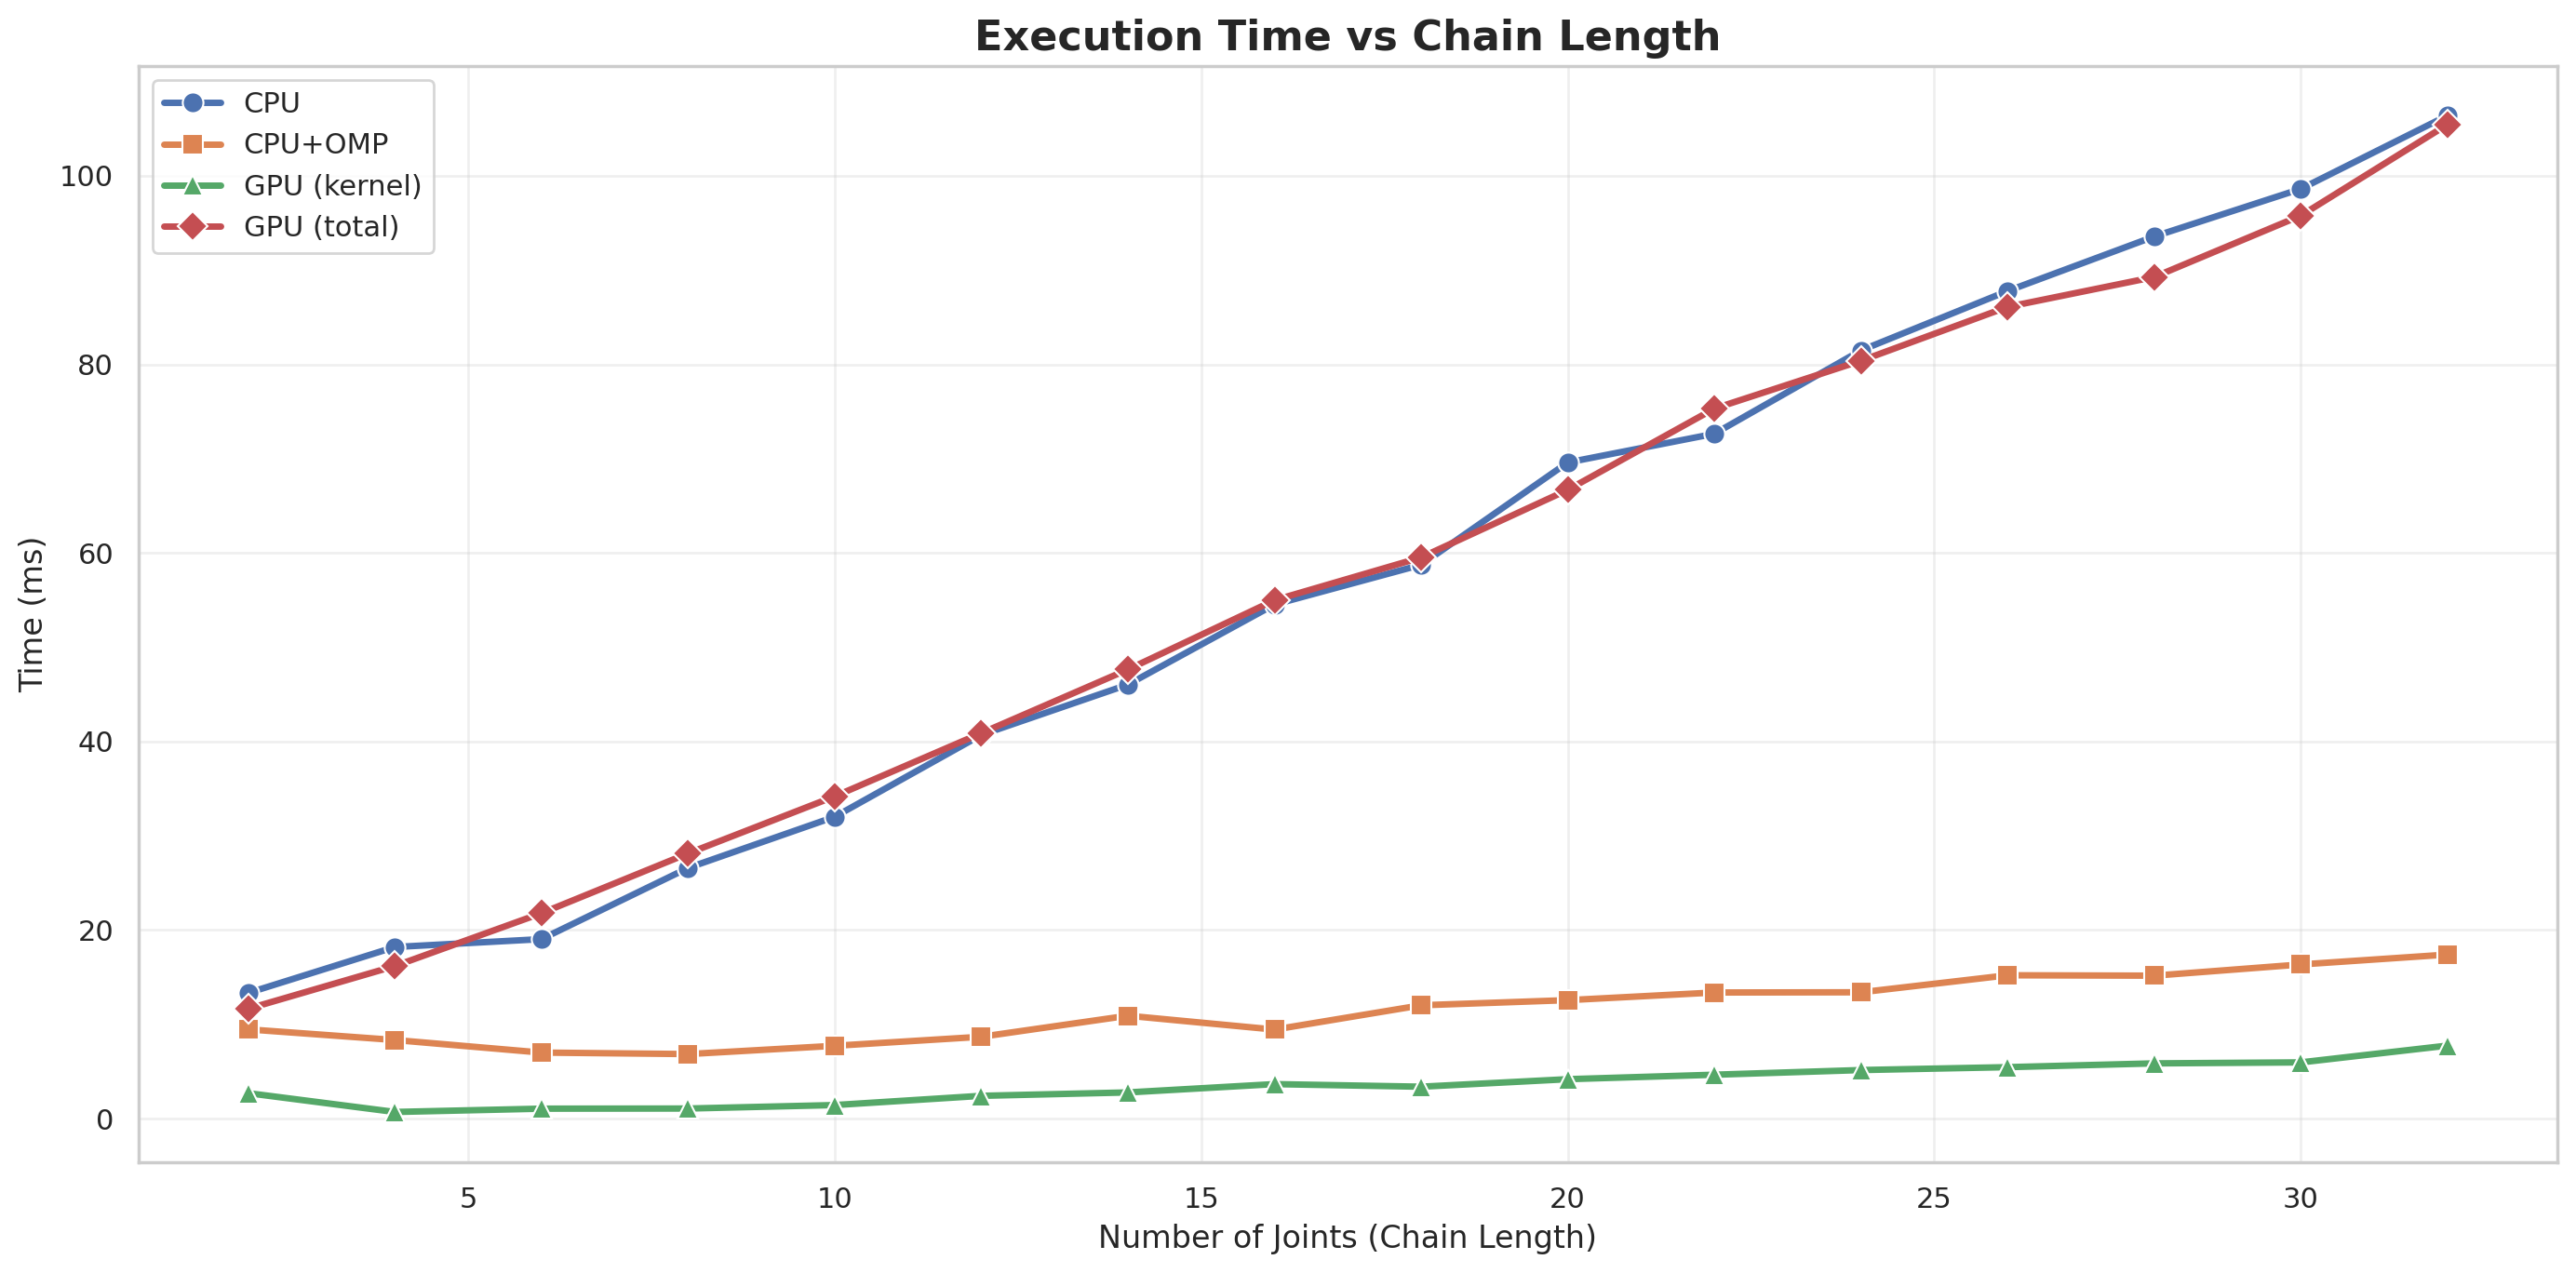

In [17]:
# Execution time vs chain length
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

sns.lineplot(data=joints_df, x='num_joints', y='cpu_ms', marker='o', linewidth=2.5, markersize=8, label='CPU', ax=ax)
sns.lineplot(data=joints_df, x='num_joints', y='omp_ms', marker='s', linewidth=2.5, markersize=8, label='CPU+OMP', ax=ax)
sns.lineplot(data=joints_df, x='num_joints', y='gpu_kernel_ms', marker='^', linewidth=2.5, markersize=8, label='GPU (kernel)', ax=ax)
sns.lineplot(data=joints_df, x='num_joints', y='total_ms', marker='D', linewidth=2.5, markersize=8, label='GPU (total)', ax=ax)

plt.title('Execution Time vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

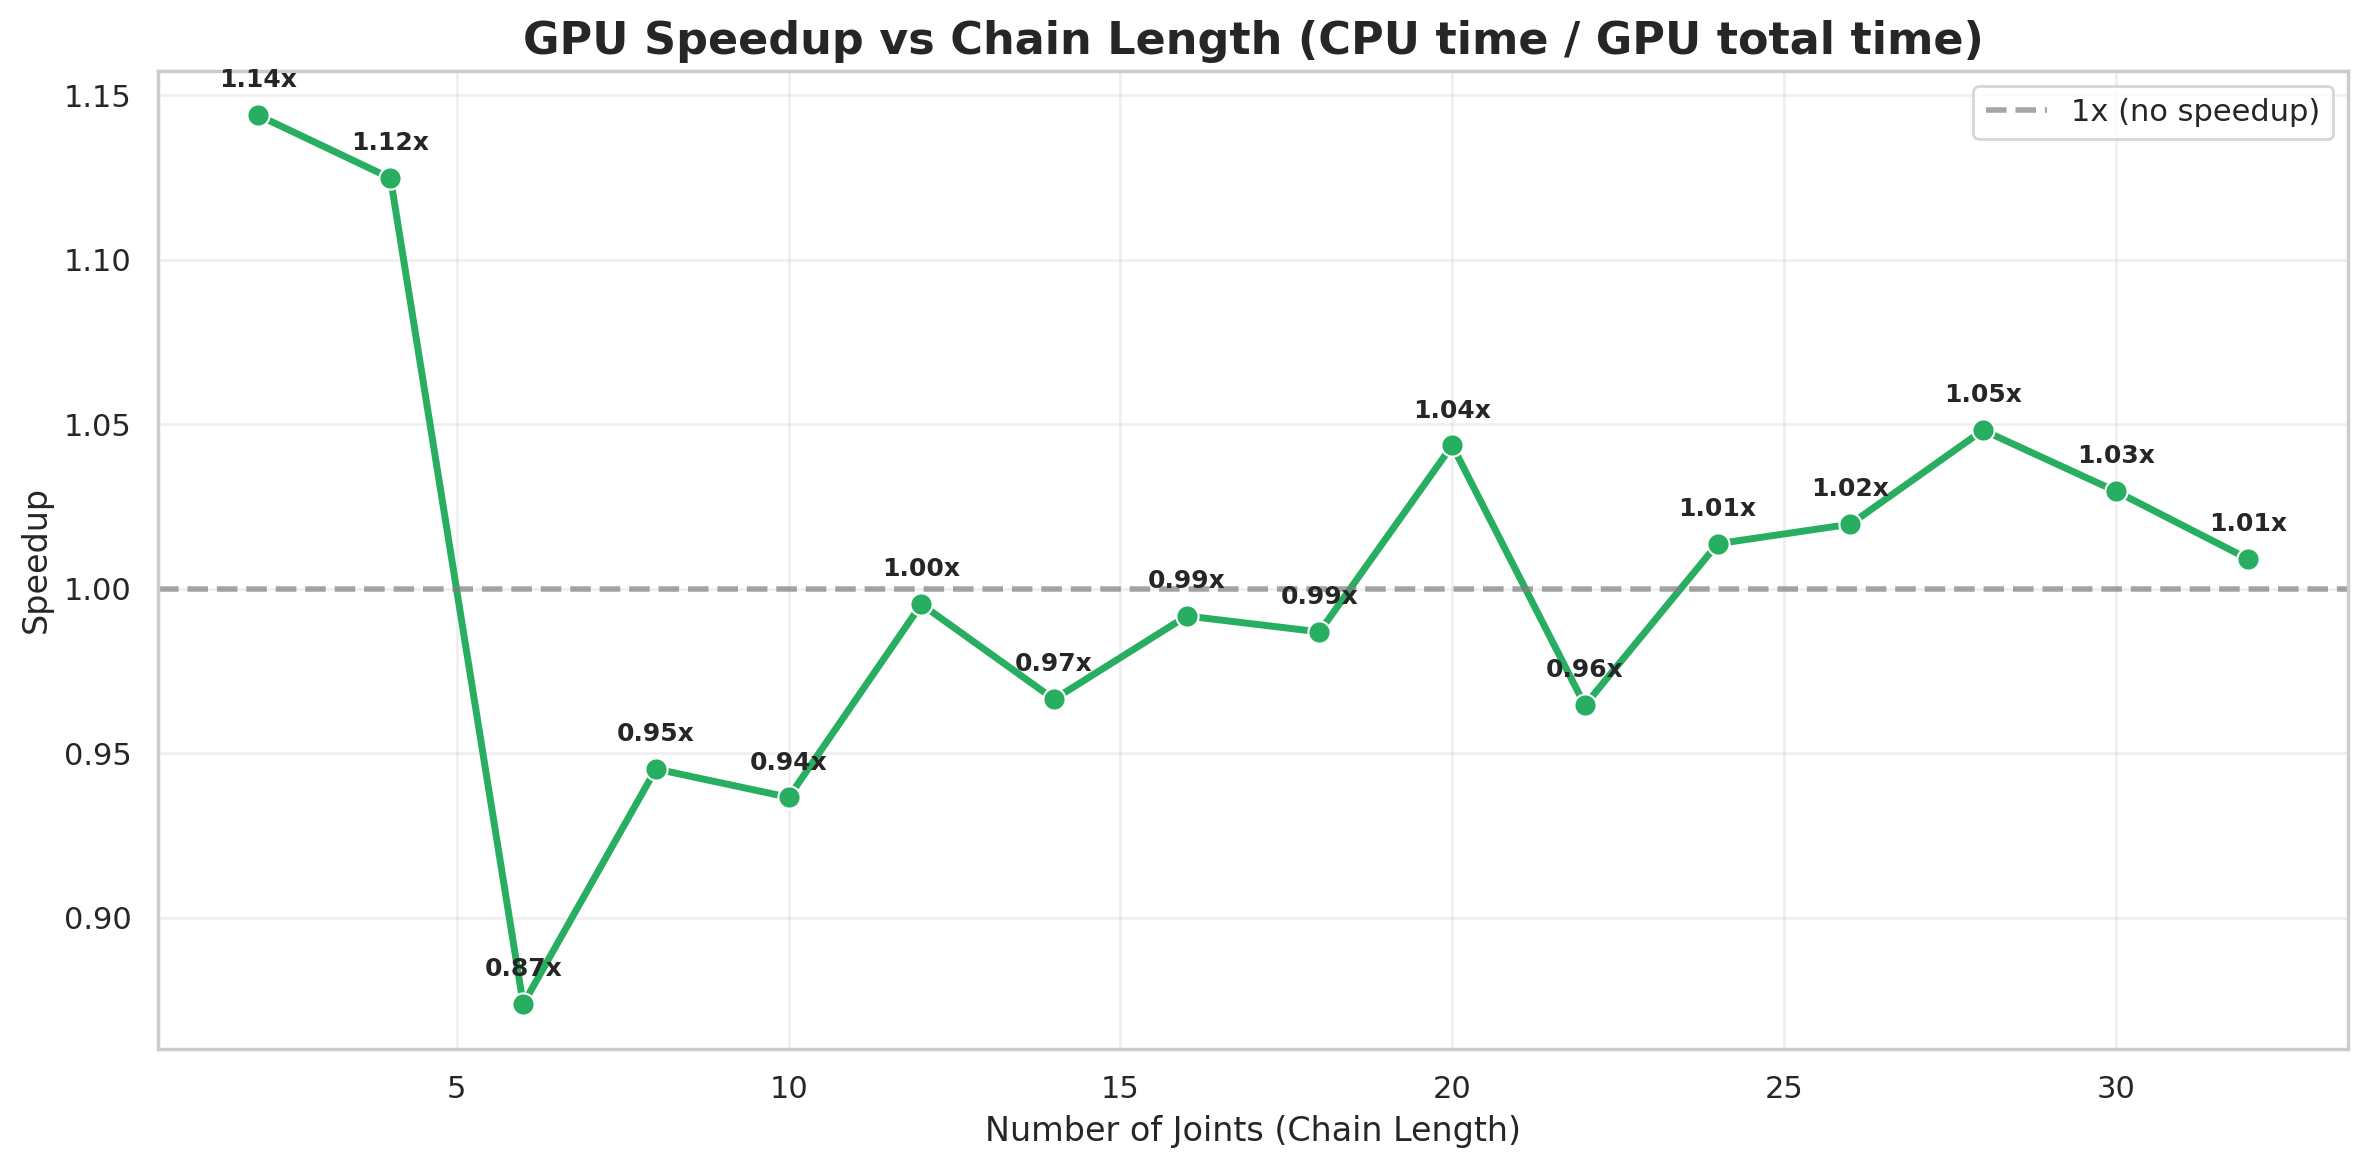

In [18]:
# GPU Speedup vs chain length
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Calculate speedup at each joint count
joints_df['speedup_vs_cpu'] = joints_df['cpu_ms'] / joints_df['total_ms']

sns.lineplot(data=joints_df, x='num_joints', y='speedup_vs_cpu', marker='o', linewidth=2.5, markersize=8, color='#27ae60', ax=ax)

# Add horizontal line at 1x speedup
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='1x (no speedup)')

plt.title('GPU Speedup vs Chain Length (CPU time / GPU total time)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add value labels on points
for idx, row in joints_df.iterrows():
    ax.annotate(f'{row["speedup_vs_cpu"]:.2f}x', 
                xy=(row['num_joints'], row['speedup_vs_cpu']),
                xytext=(0, 10), textcoords='offset points', ha='center',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

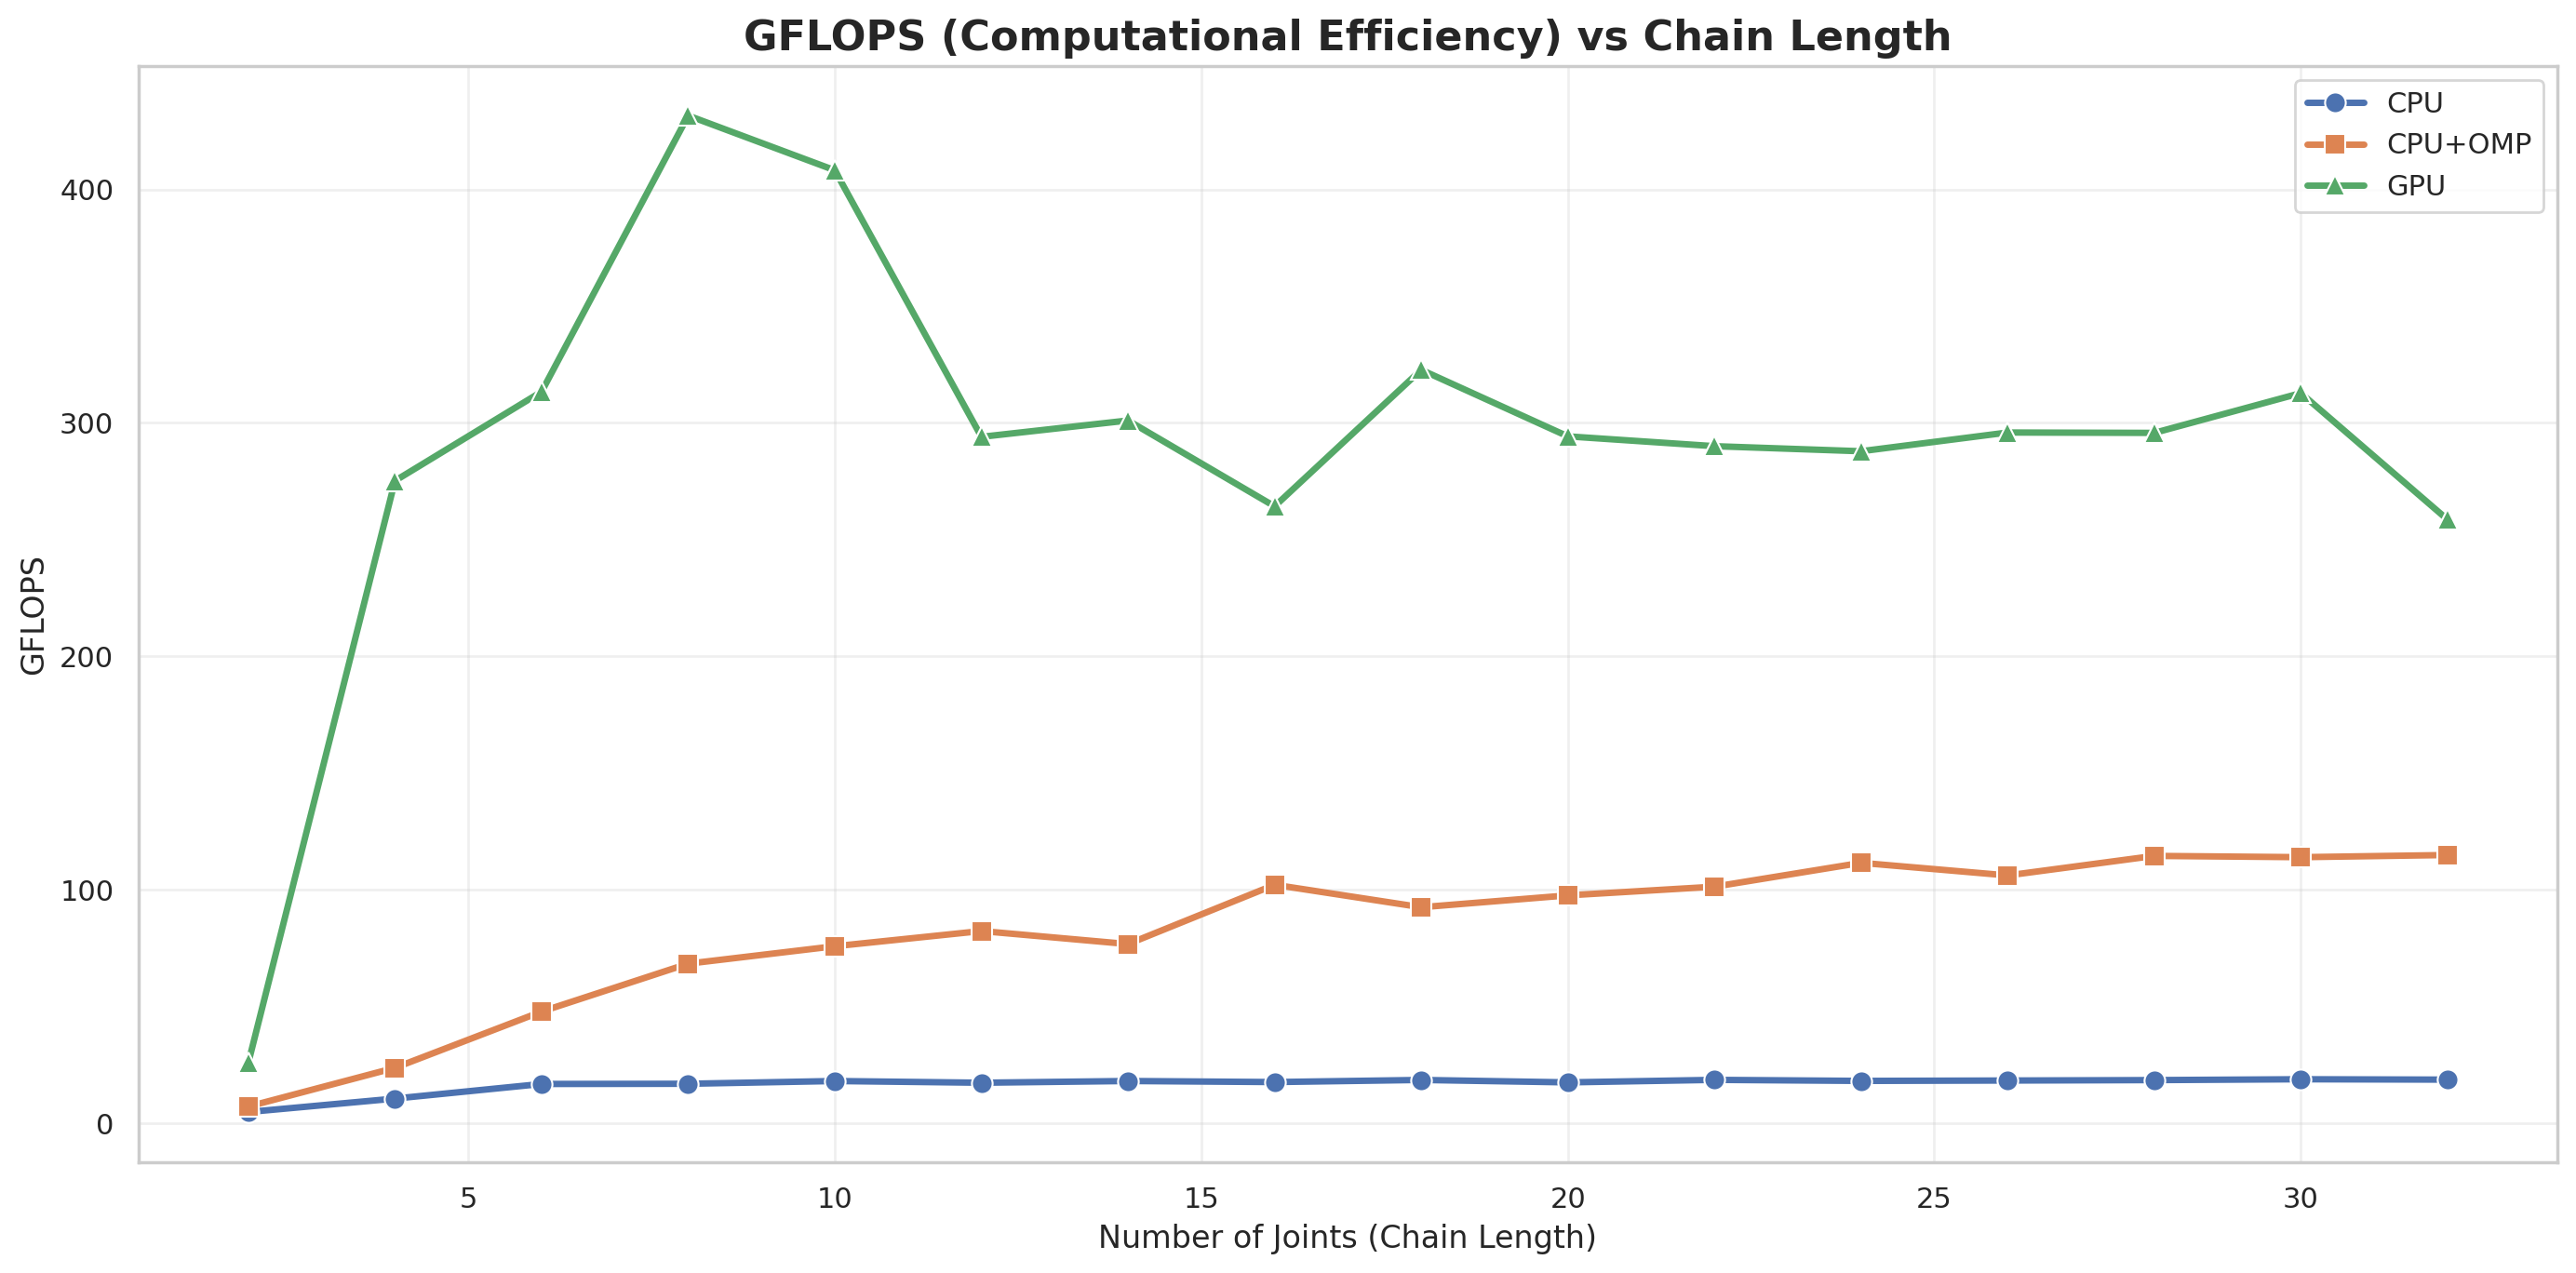

In [19]:
# GFLOPS comparison showing efficiency
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

sns.lineplot(data=joints_df, x='num_joints', y='cpu_gflops', marker='o', linewidth=2.5, markersize=8, label='CPU', ax=ax)
sns.lineplot(data=joints_df, x='num_joints', y='omp_gflops', marker='s', linewidth=2.5, markersize=8, label='CPU+OMP', ax=ax)
sns.lineplot(data=joints_df, x='num_joints', y='gpu_gflops', marker='^', linewidth=2.5, markersize=8, label='GPU', ax=ax)

plt.title('GFLOPS (Computational Efficiency) vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('GFLOPS', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

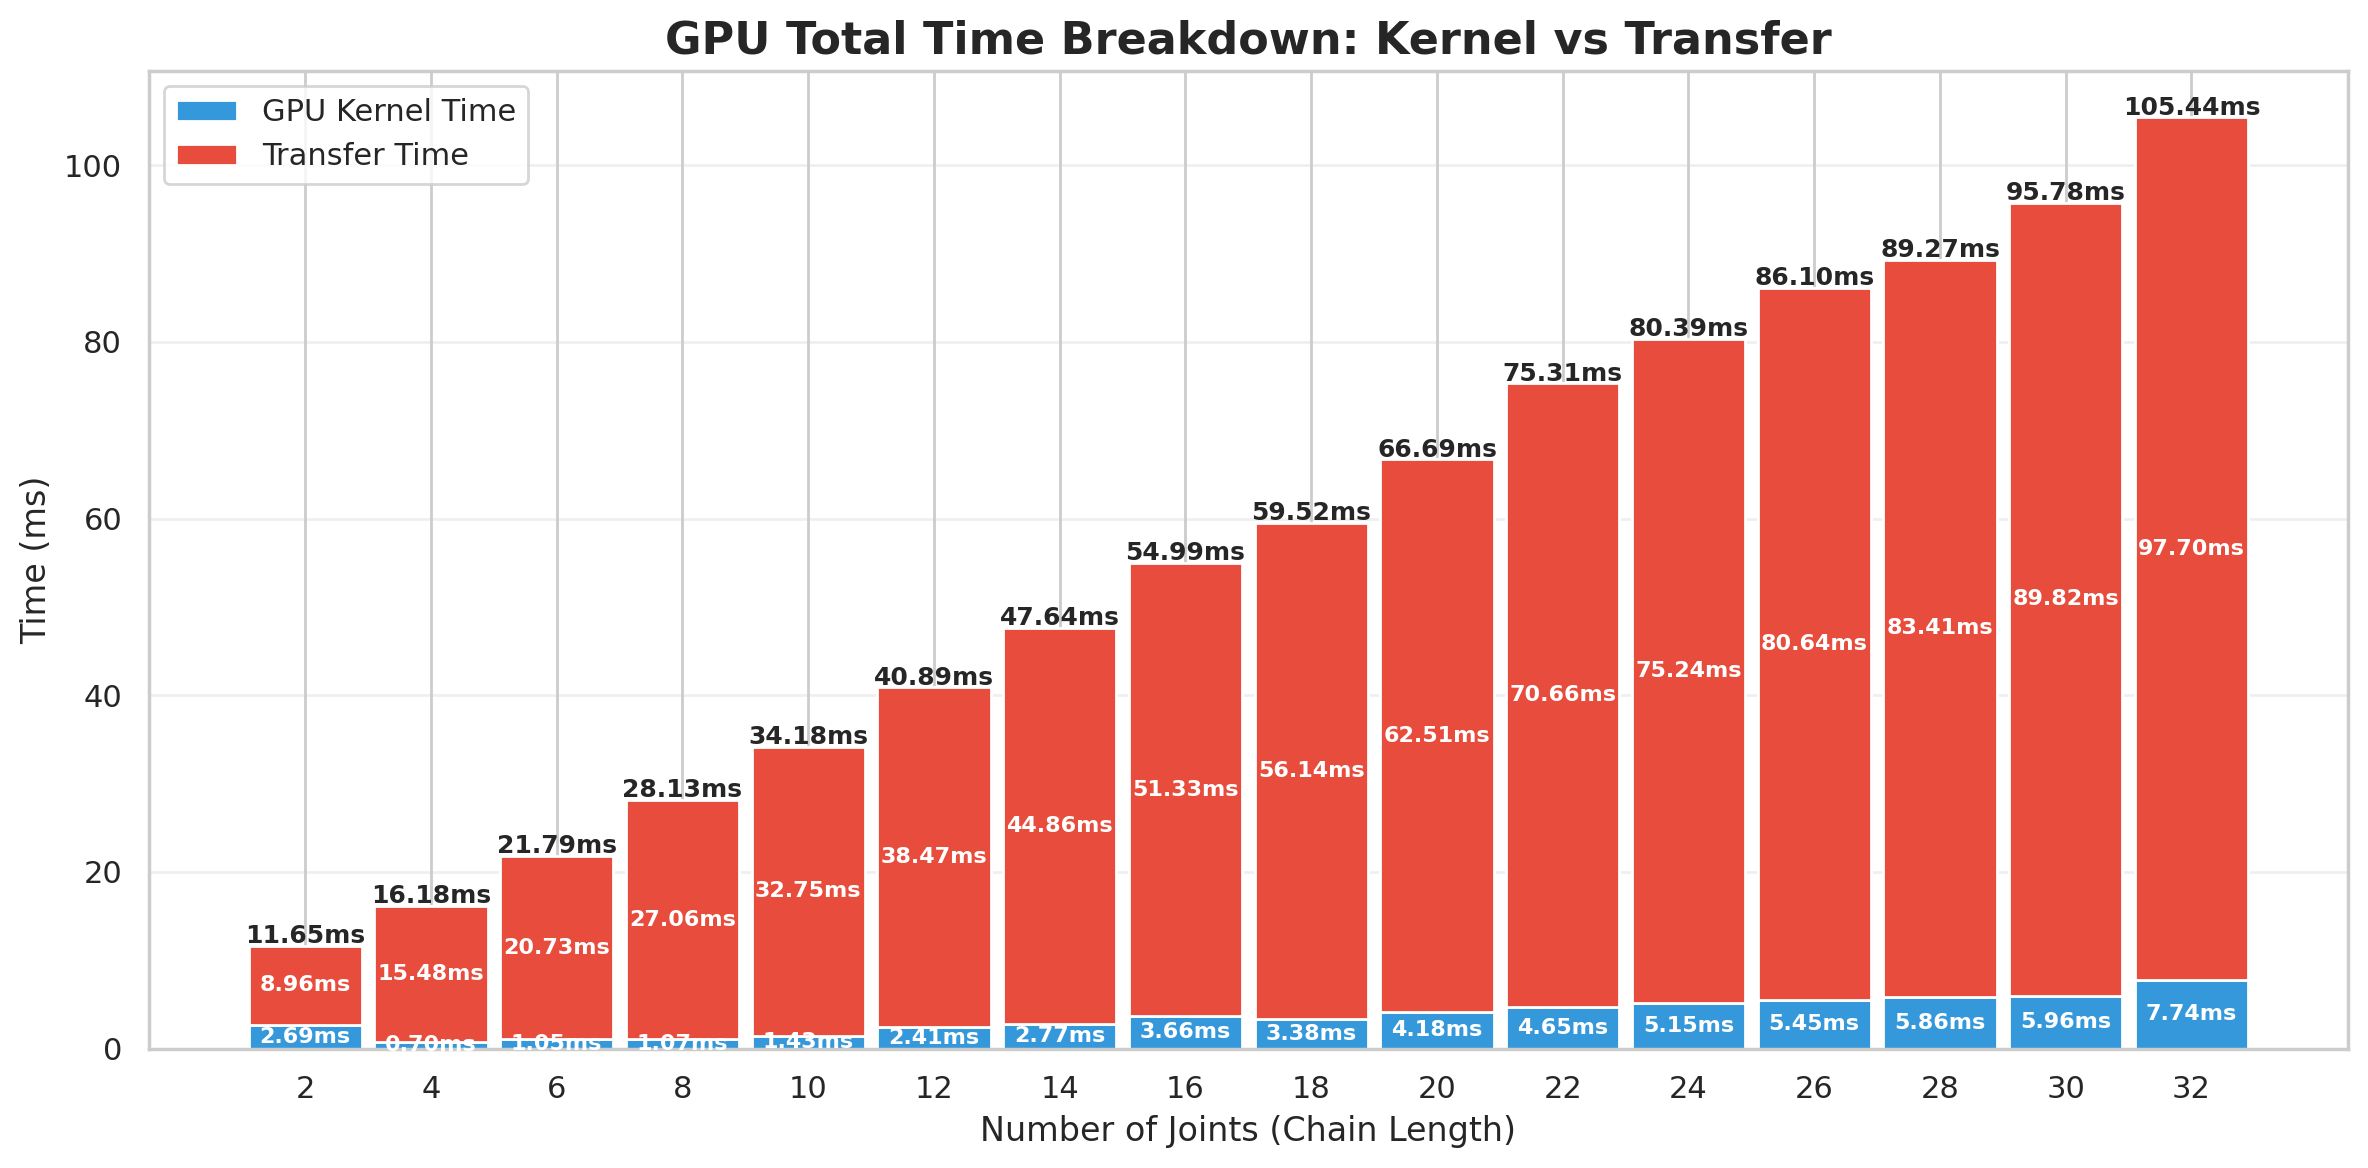

In [26]:
# Transfer vs kernel time breakdown
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Create stacked bar chart showing kernel vs transfer time
x = joints_df['num_joints'].astype(str)
kernel_times = joints_df['gpu_kernel_ms']
transfer_times = joints_df['transfer_ms']

ax.bar(x, kernel_times, label='GPU Kernel Time', color='#3498db', width=0.9)
ax.bar(x, transfer_times, bottom=kernel_times, label='Transfer Time', color='#e74c3c', width=0.9)

plt.title('GPU Total Time Breakdown: Kernel vs Transfer', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add labels for kernel time (middle of kernel section)
for i, (idx, row) in enumerate(joints_df.iterrows()):
    kernel_time = row['gpu_kernel_ms']
    transfer_time = row['transfer_ms']
    total_time = kernel_time + transfer_time
    
    # Kernel time label (in middle of kernel bar)
    ax.text(i, kernel_time / 2, f'{kernel_time:.2f}ms', 
            ha='center', va='center', fontsize=8, fontweight='bold', color='w')
    
    # Transfer time label (in middle of transfer section)
    ax.text(i, kernel_time + transfer_time / 2, f'{transfer_time:.2f}ms', 
            ha='center', va='center', fontsize=8, fontweight='bold', color='w')
    
    # Total time label on top
    ax.text(i, total_time + 0.3, f'{total_time:.2f}ms', 
            ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()